# Titulo

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Colab Notebooks/TCC/"

except:
    path = "output/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Imports
import pickle as pk
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from IPython.display import clear_output
import sklearn.neural_network as sknn

# Leitura e exploração dos dados

There are 39.92506244796004% of nominal cases


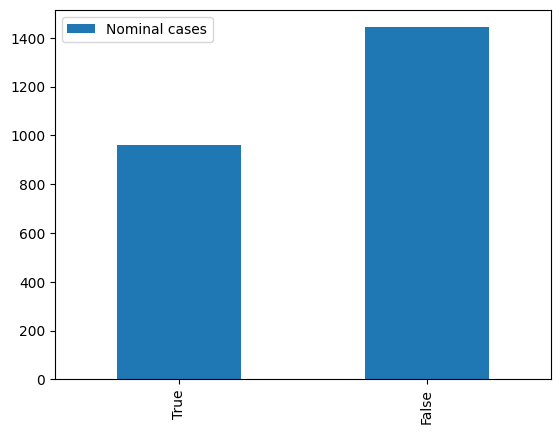

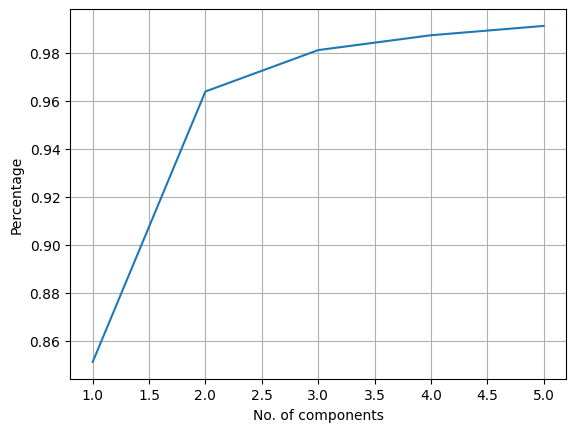

In [3]:
### Extraindo os dados
with open(path+"Tsdata.pickle", "rb") as fname:
    ([Xts]) = pk.load(fname)

with open(path+"alldata_info.pickle", "rb") as fname:
    (df2save) = pk.load(fname)

df2save['target'] = (df2save['case'] == 'A') | (df2save['case'] == 'B') | (df2save['case'] == 'C') | (df2save['case'] == 'R')
df2save['target'].value_counts().sort_values().plot(kind='bar')
plt.legend({'Nominal cases'})

print('There are ' + str(df2save['target'].sum()/len(df2save['target'])*100) + '% of nominal cases')

y = 1 - df2save['target']

### PCA + Graficos
pctExplVar = 0.99
pca = PCA(n_components=pctExplVar)
Xtsred = pca.fit_transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()

In [4]:
Xts.shape, Xtsred.shape

((2402, 48), (2402, 5))

In [5]:
Xtsred[0:5,:]

array([[-5.53551908,  1.17782852,  0.2242756 , -0.15904104, -0.24356281],
       [-5.68152683,  1.0116827 ,  0.15158924, -0.10148506, -0.08661173],
       [-5.64041655,  0.8850916 ,  0.1326918 ,  0.03178893,  0.11990451],
       [-5.74539635,  1.20623889,  0.24005609, -0.17148133, -0.23251438],
       [-5.68920261,  1.07014931,  0.13065075, -0.13051693, -0.0616693 ]])

Plotando os reusltados do PCA nos gráficos abaixo podemos observar claramente que temos alguns outliers nos dados.

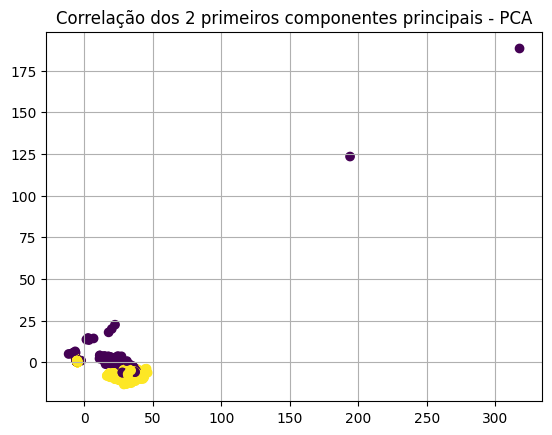

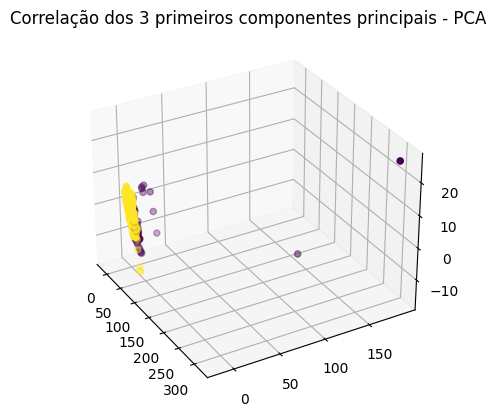

In [6]:
# Gráficos 2/3D - Resultado do PCA
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[:,0],Xtsred[:,1],c = y)
ax.grid()
ax.set_title("Correlação dos 2 primeiros componentes principais - PCA")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[:,0],Xtsred[:,1],Xtsred[:,2],c = y)
ax.set_title("Correlação dos 3 primeiros componentes principais - PCA")
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


A função abaixo foi utlizada para filtrar outliers nos dados.

In [7]:
# Função para filtrar outliers
def reject_outliers(data, m = 4.):
    data = data[:,0]
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev.all() else np.zeros(len(d))
    return s<m

map = reject_outliers(Xtsred)

Nos gráficos abaixo, podemos observar que os outliers possuem uma fração maior de casos com presença de dano quando comparado aos não outliers, mas ainda possuem uma quantidade significativa de casos nominais

383 2019 2402


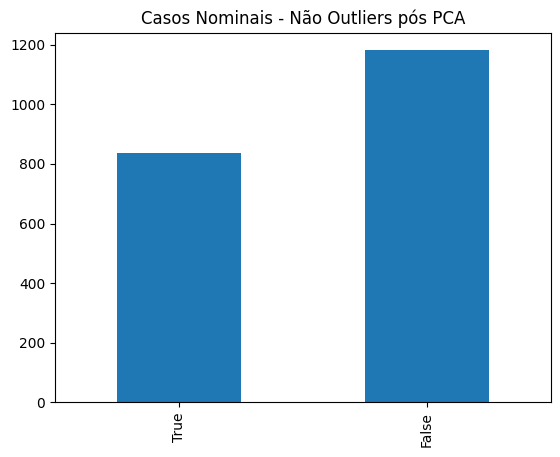

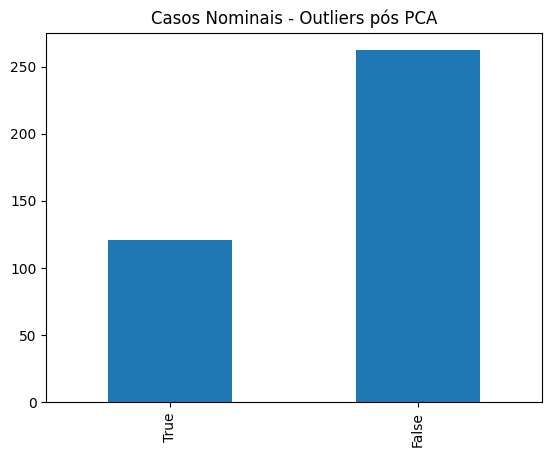

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# Graifco - Não Dano x Dano nos outliers e não outliers
print(np.sum(np.invert(map)),np.sum(map),len(map))
df2save['target'].loc[map].value_counts().sort_values().plot(kind='bar')

plt.title("Casos Nominais - Não Outliers pós PCA")
plt.show()
plt.figure()

df2save['target'].loc[np.invert(map)].value_counts().sort_values().plot(kind='bar')
plt.title("Casos Nominais - Outliers pós PCA")
plt.show()
plt.figure()

Realizamos novamente os gráficos para autocorrelação ddos componentes principais, dessa vez filtrando os outliers. A função de filtragem parece ter sido adequada.

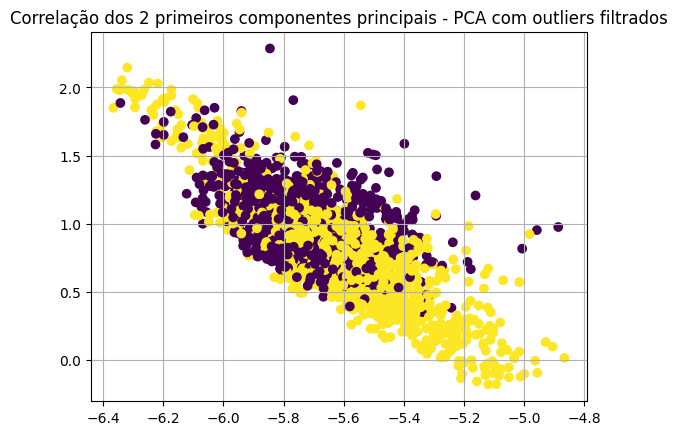

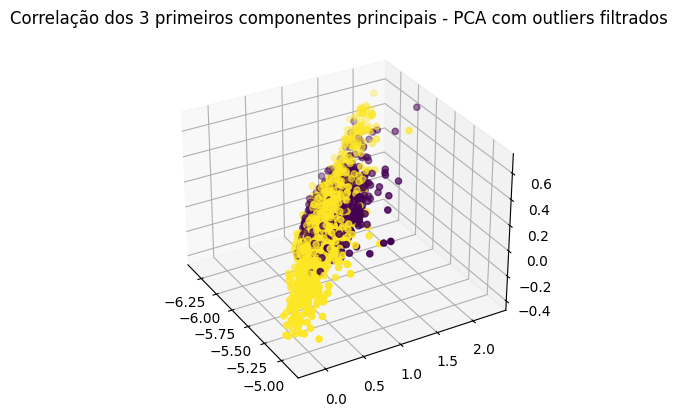

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[map,0],Xtsred[map,1],c = y[map])
ax.set_title("Correlação dos 2 primeiros componentes principais - PCA com outliers filtrados")
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.set_title("Correlação dos 3 primeiros componentes principais - PCA com outliers filtrados")
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


Hipotese alternativa: Realizar a filtragem de outliers antes do PCA.

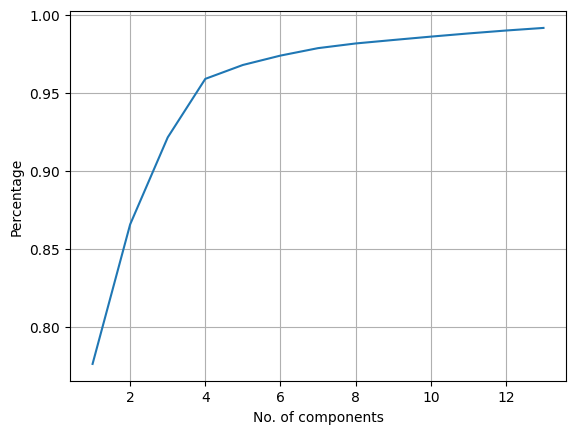

2402
2012 None


In [10]:
# Filtragem + PCA
pctExplVar = 0.99
pca2 = PCA(n_components=pctExplVar)

#Realizamos o fit no conjunto filtrado, mas mantemos o conjunto inteiro após a transformada
map_xts = reject_outliers(Xts)
pca2.fit(Xts[map_xts])
Xtsred_filtered = pca2.transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca2.explained_variance_ratio_)))+1,np.cumsum(pca2.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()
print(sum(map_xts),print(len(Xts)))

Observamos que ao remover os outliers antes de realizar o PCA, o numero de componentes necessários para atingir 99% de variancia explicada sobe drasticamente, de 5 para 13.

Abaixo, plotamos o grafico de autocorrelação para os componentes principais do novo PCA obtido. Observe que os outliers foram mantidos apos a transformada, tendo sido apenas desconsiderados para montar a matriz do PCA.

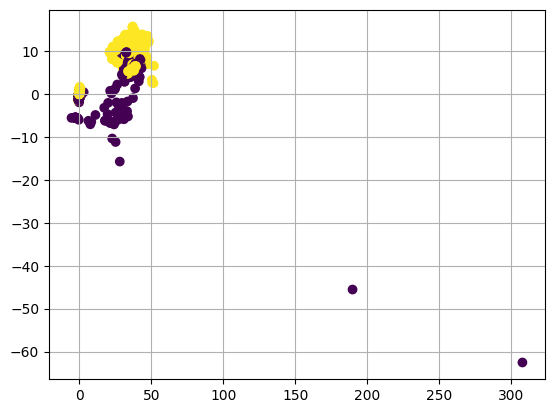

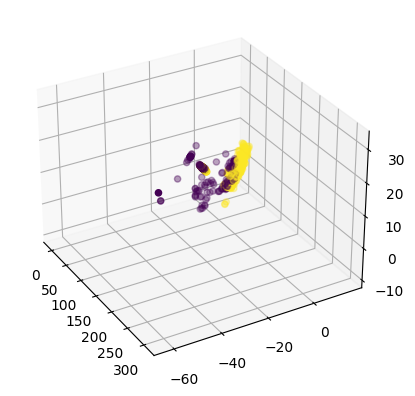

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],c = y)
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],Xtsred_filtered[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()

# Testing without PCA

In [12]:
index_modelos = ["Decision tree","Ridge classifier","SVC"]

In [46]:
#dir(tree)
print(tree.get_depth())
print(tree.get_n_leaves())
print(tree.get_params())

19
180
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [43]:
X = StandardScaler().fit_transform(X=Xts)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

print("Confusion matrix results:")
print(confusion_matrix(y_test, ytree))
print(confusion_matrix(y_test, yridg))
print(confusion_matrix(y_test, ysvc))
print()

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_no_pca = pd.DataFrame(test_results, index = index_modelos)
print(df_no_pca)

Confusion matrix results:
[[378  20]
 [ 23 540]]
[[337  61]
 [ 10 553]]
[[322  76]
 [ 13 550]]

Balanced accuracy
0.9544480841150691
0.9144858394994511
0.8929773199925024

F1 score
0.9617097061442564
0.9396771452846218
0.9251471825063078

Recall score
0.9591474245115453
0.9822380106571936
0.9769094138543517
                        BA        F1    Recall
Decision tree     0.954448  0.961710  0.959147
Ridge classifier  0.914486  0.939677  0.982238
SVC               0.892977  0.925147  0.976909


# Testing with basic PCA

In [28]:
X = StandardScaler().fit_transform(X=Xtsred)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca1 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca1)

Balanced accuracy
0.7766162071458536
0.5388353847389702
0.8009853887555004

F1 score
0.8156028368794327
0.7408431237042156
0.8510998307952622

Recall score
0.8170515097690941
0.9520426287744227
0.8934280639431617
                        BA        F1    Recall
Decision tree     0.776616  0.815603  0.817052
Ridge classifier  0.538835  0.740843  0.952043
SVC               0.800985  0.851100  0.893428


# Testing filtering after PCA

In [45]:
X = StandardScaler().fit_transform(X=Xtsred[map,:])

X_train, X_test, y_train, y_test = train_test_split(X, y[map],test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca2 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca2)

Balanced accuracy
0.7533445289356002
0.8092627884597241
0.8417992213395726

F1 score
0.7833698030634574
0.8423280423280423
0.8663101604278075

Recall score
0.7633262260127932
0.8486140724946695
0.8635394456289979
                        BA        F1    Recall
Decision tree     0.753345  0.783370  0.763326
Ridge classifier  0.809263  0.842328  0.848614
SVC               0.841799  0.866310  0.863539


# Testing filtering before PCA

In [47]:
X = StandardScaler().fit_transform(X=Xtsred_filtered)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca3 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca3)

Balanced accuracy
0.8467961477012058
0.8156501869917974
0.8749341735319582

F1 score
0.8759894459102903
0.8705688375927453
0.9107744107744108

Recall score
0.8845470692717584
0.9378330373001776
0.9609236234458259
                        BA        F1    Recall
Decision tree     0.846796  0.875989  0.884547
Ridge classifier  0.815650  0.870569  0.937833
SVC               0.874934  0.910774  0.960924


Resultados obtidos antes da busca de parametros:

In [17]:
df_resultados = pd.concat([df_no_pca, df_pca1, df_pca2, df_pca3], keys=['No PCA', 'PCA', 'PCA -> Filter', 'Filter -> PCA'])
df_resultados

BA        F1    Recall
No PCA        Decision tree     0.954448  0.961710  0.959147
              Ridge classifier  0.914486  0.939677  0.982238
              SVC               0.892977  0.925147  0.976909
PCA           Decision tree     0.771223  0.813051  0.818828
              Ridge classifier  0.538835  0.740843  0.952043
              SVC               0.800985  0.851100  0.893428
PCA -> Filter Decision tree     0.763829  0.786667  0.754797
              Ridge classifier  0.809263  0.842328  0.848614
              SVC               0.841799  0.866310  0.863539
Filter -> PCA Decision tree     0.857734  0.883186  0.886323
              Ridge classifier  0.815650  0.870569  0.937833
              SVC               0.874934  0.910774  0.960924

Observamos que os modelos treinados no conjunto original dos dados obtiveram consistentemente uma melhor performance quando comparados aos modelos treinados com o uso de PCA. Além disso, observamos que dentre os 3 testes com PCA realizados, aplicar a filtragem de outliers antes de utilizar o metodo demonstrou resultados melhores.

Para o PCA simples houve um resultado particurlarmente bom para o ridge classifier, com um recall de 0.95. Utilizando o filtro pos-PCA aumentou significativamente a performance desse modelo.

# Parameter search:

In [61]:
param_dist = {
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[None,10,15],
    "max_leaf_nodes":[None,50,100],
    "max_features" :[None],
    "splitter":["best"]
}

tree = DecisionTreeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
#tree_random_search = RandomizedSearchCV(tree, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = 5)
tree_random_search = GridSearchCV(tree, param_dist, verbose = 2, cv = rkf)
tree_search_result = tree_random_search.fit(X_train, y_train)

clear_output()
print(tree_search_result.best_params_)

tree = DecisionTreeClassifier(**tree_search_result.best_params_)
tree.fit(X_train,y_train)
yytree = tree.predict(X_test)

print("tree results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yytree))
print(metrics.f1_score(y_test, yytree))
print(metrics.recall_score(y_test, yytree))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, ytree))
print(metrics.f1_score(y_test, ytree))
print(metrics.recall_score(y_test, ytree))

{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'splitter': 'best'}
tree results
Optimized
0.8672871462106269
0.8954703832752613
0.9129662522202486
Unoptimezed
0.8467961477012058
0.8759894459102903
0.8845470692717584


In [57]:
param_dist = {
    "alpha": sp_randFloat(0,2),
    "class_weight":["balanced",None],
    "solver":["svd","cholesky","lsqr","sparse_cg","sag","saga","lbfgs"]
}

ridg = RidgeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
ridg_random_search = RandomizedSearchCV(ridg, param_dist, random_state=0, n_iter = 100, verbose = 2, cv = rkf)
ridg_search_result = ridg_random_search.fit(X_train, y_train)

clear_output()
print(ridg_search_result.best_params_)

ridg = RidgeClassifier(**ridg_search_result.best_params_)
ridg.fit(X_train,y_train)
yyridg = ridg.predict(X_test)

print("ridg results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yyridg))
print(metrics.f1_score(y_test, yyridg))
print(metrics.recall_score(y_test, yyridg))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yridg))
print(metrics.f1_score(y_test, yridg))
print(metrics.recall_score(y_test, yridg))

{'alpha': 0.023428168370003943, 'class_weight': None, 'solver': 'saga'}
ridg results
Optimized
0.8147620875246571
0.8696369636963696
0.9360568383658969
Unoptimezed
0.8156501869917974
0.8705688375927453
0.9378330373001776


In [58]:
param_dist = {
    "kernel":['linear','poly', 'rbf', 'sigmoid'],
    "gamma":["auto","scale"],
    "coef0":sp_randFloat(-1,1),
    "degree":sp_randInt(2,6)
}

svc = SVC()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
svc_random_search = RandomizedSearchCV(svc, param_dist, random_state=0, n_iter = 100, verbose = 2, cv = rkf)
svc_search_result = svc_random_search.fit(X_train, y_train)

clear_output()
print(svc_search_result.best_params_)

svc = SVC(**svc_search_result.best_params_)
svc.fit(X_train,y_train)
yysvc = svc.predict(X_test)

print("SVC results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yysvc))
print(metrics.f1_score(y_test, yysvc))
print(metrics.recall_score(y_test, yysvc))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, ysvc))
print(metrics.f1_score(y_test, ysvc))
print(metrics.recall_score(y_test, ysvc))

{'coef0': -0.07884238976280022, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
SVC results
Optimized
0.8769268188187831
0.9112426035502958
0.9573712255772646
Unoptimezed
0.8749341735319582
0.9107744107744108
0.9609236234458259
